# An unoffical demo for training MCNN on Shanghai tech dataset (Part-B)

## Imports

In [5]:
import pandas as pd
import numpy as np

In [6]:
import scipy
import scipy.io
import cv2

from matplotlib import pyplot as plt

from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from PIL import Image

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning import seed_everything

import os

## visualize

In [7]:
def show(im):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

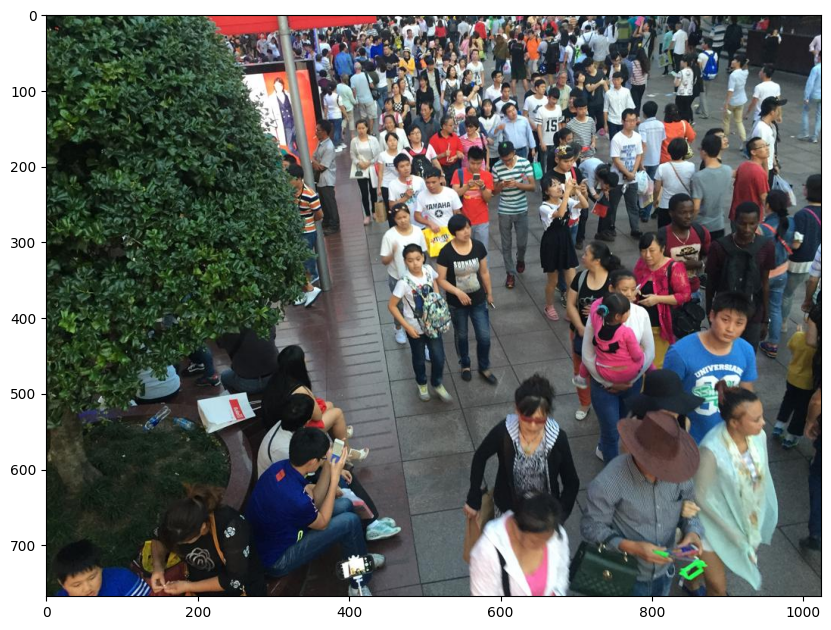

In [8]:
im = cv2.imread('ShanghaiTech/part_B/train_data/images/IMG_1.jpg', cv2.IMREAD_COLOR)
show(im)

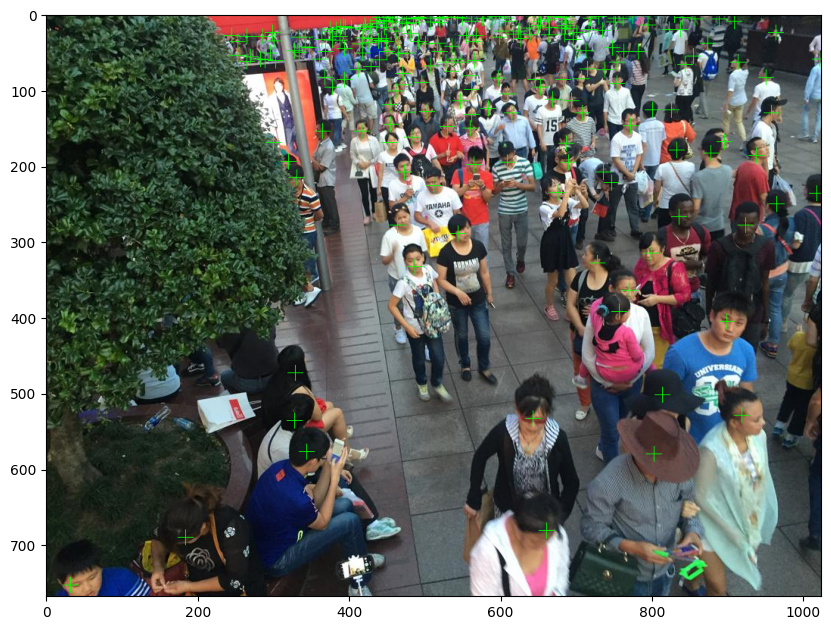

In [9]:
m = scipy.io.loadmat('ShanghaiTech/part_B/train_data/ground-truth/GT_IMG_1.mat')
ps = m['image_info'][0][0][0][0][0]

for x, y in ps:
    x = int(x)
    y = int(y)
    cv2.drawMarker(im, (x, y), (0, 255, 0))
    
show(im)

## Prepare dataset

In [10]:
from sklearn.model_selection import train_test_split

train = [p.path for p in os.scandir('ShanghaiTech/part_B/train_data/images/')]
valid_full = [p.path for p in os.scandir('ShanghaiTech/part_B/test_data/images/')]

## use a small subset for validation
_, valid = train_test_split(valid_full, test_size=64, random_state=42)

len(train), len(valid)

(400, 64)

In [13]:
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [14]:
im_size = 512
aug_train = A.Compose([
    A.RandomCrop(im_size, im_size),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(),
    A.Normalize((0.5), (0.5)),
], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=False))

aug_val = A.Compose([
    A.Resize(768, 1024),
    A.Normalize((0.5), (0.5)),
], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=False))

class MyDataset(Dataset):
    def __init__(self, files, aug):
        self.files = files
        self.aug = aug
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fn = self.files[idx]
        
        im = cv2.imread(fn, cv2.IMREAD_COLOR)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        
        m = scipy.io.loadmat(fn.replace('images', 'ground-truth').replace('IMG', 'GT_IMG').replace('.jpg', '.mat'))
        ps = m['image_info'][0][0][0][0][0]
        
        rst = self.aug(image=im, keypoints=ps)
        im = rst['image']
        ps = rst['keypoints']
        
        dm = np.zeros((im.shape[0], im.shape[1]), dtype=np.float32)
        for x, y in ps:
            x = int(x)
            y = int(y)
            dm[y, x] = 1

        sigma = 4
        dm = gaussian_filter(dm, sigma=sigma, truncate=4*sigma)
        
        dm = cv2.resize(dm, (im.shape[1] // 4, im.shape[0] // 4), interpolation=cv2.INTER_LINEAR)
        dm *= 16
        
        im = torch.from_numpy(im)
        dm = torch.from_numpy(dm)
        
        return im, dm

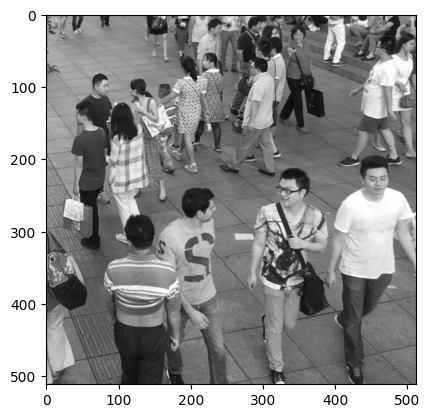

In [15]:
ds = MyDataset(train, aug_train)
im, dm = ds[0]
plt.imshow(im, cmap='gray')

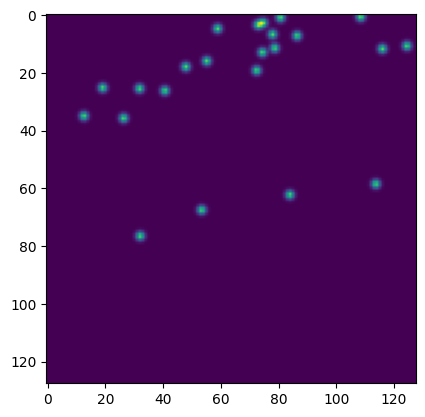

In [16]:
plt.imshow(dm)

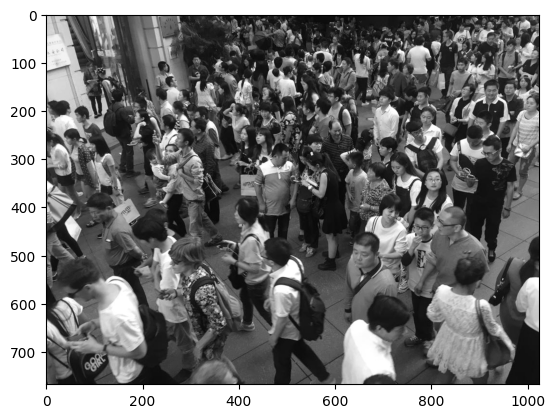

In [17]:
ds = MyDataset(valid, aug_val)
im, dm = ds[0]
plt.imshow(im, cmap='gray')

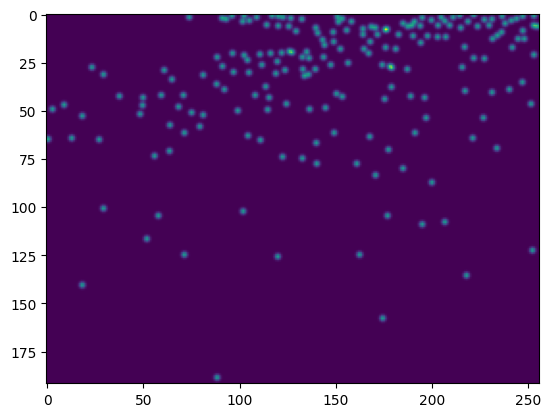

In [18]:
plt.imshow(dm)

In [19]:
dm.sum()

tensor(196.)

## Building Model

In [20]:
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, \
                stride=1, NL='relu', same_padding=False, bn=False, dilation=1):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) // 2) if same_padding else 0
        self.conv = []
        if dilation==1:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding, dilation=dilation)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=dilation, dilation=dilation)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else nn.Identity()
        if NL == 'relu' :
            self.relu = nn.ReLU(inplace=True)
        elif NL == 'prelu':
            self.relu = nn.PReLU()
        else:
            self.relu = None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

In [21]:
class MCNN(LightningModule):
    '''
    Multi-column CNN 
        -Implementation of Single Image Crowd Counting via Multi-column CNN (Zhang et al.)
    '''
    
    def __init__(self, lr, batch_size, max_steps, bn=False):
        super(MCNN, self).__init__()
        
        self.lr = lr
        self.save_hyperparameters()
        
        self.use = 0
        
        self.branch1 = nn.Sequential(Conv2d( 1, 16, 9, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(16, 32, 7, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(32, 16, 7, same_padding=True, bn=bn),
                                     Conv2d(16,  8, 7, same_padding=True, bn=bn))
        
        self.branch2 = nn.Sequential(Conv2d( 1, 20, 7, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(20, 40, 5, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(40, 20, 5, same_padding=True, bn=bn),
                                     Conv2d(20, 10, 5, same_padding=True, bn=bn))
        
        self.branch3 = nn.Sequential(Conv2d( 1, 24, 5, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(24, 48, 3, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(48, 24, 3, same_padding=True, bn=bn),
                                     Conv2d(24, 12, 3, same_padding=True, bn=bn))
        
        self.fuse = nn.Sequential(Conv2d( 30, 1, 1, same_padding=True, bn=bn))
        
        self.out1 = nn.Sequential(Conv2d( 8, 1, 1, same_padding=True, bn=bn))
        self.out2 = nn.Sequential(Conv2d( 10, 1, 1, same_padding=True, bn=bn))
        self.out3 = nn.Sequential(Conv2d( 12, 1, 1, same_padding=True, bn=bn))
        
        self.crit = nn.MSELoss()
        
    def forward(self, im_data):
        im_data = im_data.unsqueeze(1)
        x1 = self.branch1(im_data)
        x2 = self.branch2(im_data)
        x3 = self.branch3(im_data)
        
        
        if self.use == 0:
            x = torch.cat((x1,x2,x3),1)
            x = self.fuse(x)
        elif self.use == 1:
            x = self.out1(x1)
        elif self.use == 2:
            x = self.out2(x2)
        elif self.use == 3:
            x = self.out3(x3)
        
        return x.squeeze(1)
    
    
    def training_step(self, batch, batch_idx):
        self.train()
        x, y = batch
        
        pred = self(x)
        loss = self.crit(pred, y)
        
        pred_sum = torch.round(pred.sum(dim=(1,2))).int()
        gt_sum = torch.round(y.sum(dim=(1,2))).int()
        acc = (pred_sum == gt_sum).float().mean()
        
        mae = torch.abs(pred_sum - gt_sum).float().mean()
        
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        self.log('train_mae', mae)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            self.eval()
            x, y = batch
            
            pred = self(x)
            loss = self.crit(pred, y)
        
            pred_sum = torch.round(pred.sum(dim=(1,2))).int()
            gt_sum = torch.round(y.sum(dim=(1,2))).int()
            acc = (pred_sum == gt_sum).float().mean()

            mae = torch.abs(pred_sum - gt_sum).float().mean()
            
            self.log('val_loss', loss)
            self.log('val_acc', acc)
            self.log('val_mae', mae)
            
            
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-4)
        
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.lr, total_steps=self.hparams.max_steps, pct_start=0.1, cycle_momentum=False),
            'interval': 'step',
            'frequency': 1
        }
        
        return [optimizer], [scheduler]
    
    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return val_loader

### weight init is crucial for the model to converge

In [22]:
def weights_normal_init(model, dev=0.01):
    if isinstance(model, list):
        for m in model:
            weights_normal_init(m, dev)
    else:
        for n, m in model.named_modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, dev)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, dev)

## Training

In [23]:
batch_size = 32
epochs = 300
max_steps = epochs * len(train) // batch_size

In [24]:
train_loader = DataLoader(MyDataset(train, aug_train), batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=0)
val_loader = DataLoader(MyDataset(valid, aug_val), batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)


### training

In [25]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning import seed_everything, Trainer


seed_everything(42)

checkpoint_cb = ModelCheckpoint(
    save_top_k=1,
    save_last=True,
    verbose=True,
    monitor='val_mae',
    mode='min',
    filename="{epoch}-{step}"
)

trainer = Trainer(max_steps=max_steps, precision='16-mixed', benchmark=True, callbacks=[checkpoint_cb, LearningRateMonitor()])

lr = 3e-4

model = MCNN(lr, batch_size, max_steps)
weights_normal_init(model, dev=0.01)

model.use = 0

trainer.fit(model)

# Here's the code to save your model
torch.save(model.state_dict(), 'mcnn_model.pth')


Seed set to 42


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/junyong/GY/MCNN/lightning_logs
2024-02-17 23:17:34.858931: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/junyong/miniconda3/envs/GY/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.
/home/junyong/miniconda3/envs/GY/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.
/home/junyong/miniconda3/envs/GY/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 12: 'val_mae' reached 116.06250 (best 116.06250), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=0-step=12.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 24: 'val_mae' reached 107.28125 (best 107.28125), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=1-step=24.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 36: 'val_mae' reached 96.03125 (best 96.03125), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=2-step=36.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 48: 'val_mae' reached 83.21875 (best 83.21875), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=3-step=48.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 60: 'val_mae' reached 71.92188 (best 71.92188), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=4-step=60.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 72: 'val_mae' reached 69.84375 (best 69.84375), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=5-step=72.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 84: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 96: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 108: 'val_mae' reached 69.53125 (best 69.53125), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=8-step=108.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 120: 'val_mae' reached 68.53125 (best 68.53125), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=9-step=120.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 132: 'val_mae' reached 62.18750 (best 62.18750), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=10-step=132.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 144: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 156: 'val_mae' reached 55.53125 (best 55.53125), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=12-step=156.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 168: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 180: 'val_mae' reached 53.15625 (best 53.15625), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=14-step=180.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 192: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 204: 'val_mae' reached 49.96875 (best 49.96875), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=16-step=204.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 216: 'val_mae' reached 49.90625 (best 49.90625), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=17-step=216.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 228: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 240: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 252: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 264: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 276: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 288: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 300: 'val_mae' reached 49.45312 (best 49.45312), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=24-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 312: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 324: 'val_mae' reached 48.93750 (best 48.93750), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=26-step=324.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 336: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 348: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 360: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 372: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 384: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 396: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 408: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 420: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 432: 'val_mae' reached 46.93750 (best 46.93750), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=35-step=432.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 444: 'val_mae' reached 44.62500 (best 44.62500), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=36-step=444.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 456: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 468: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 480: 'val_mae' reached 42.01562 (best 42.01562), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=39-step=480.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 492: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41, global step 504: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 516: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43, global step 528: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44, global step 540: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 552: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46, global step 564: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47, global step 576: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 588: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 600: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50, global step 612: 'val_mae' reached 38.81250 (best 38.81250), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=50-step=612.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51, global step 624: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52, global step 636: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53, global step 648: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54, global step 660: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55, global step 672: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56, global step 684: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57, global step 696: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58, global step 708: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59, global step 720: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60, global step 732: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61, global step 744: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62, global step 756: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63, global step 768: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64, global step 780: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65, global step 792: 'val_mae' reached 38.20312 (best 38.20312), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=65-step=792.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66, global step 804: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67, global step 816: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68, global step 828: 'val_mae' reached 37.32812 (best 37.32812), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=68-step=828.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69, global step 840: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70, global step 852: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71, global step 864: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72, global step 876: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73, global step 888: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74, global step 900: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75, global step 912: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76, global step 924: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77, global step 936: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78, global step 948: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79, global step 960: 'val_mae' reached 34.95312 (best 34.95312), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=79-step=960.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 80, global step 972: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 81, global step 984: 'val_mae' reached 34.25000 (best 34.25000), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=81-step=984.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 82, global step 996: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 83, global step 1008: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 84, global step 1020: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 85, global step 1032: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 86, global step 1044: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 87, global step 1056: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 88, global step 1068: 'val_mae' reached 33.64062 (best 33.64062), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=88-step=1068.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 89, global step 1080: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 90, global step 1092: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 91, global step 1104: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 92, global step 1116: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 93, global step 1128: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 94, global step 1140: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 95, global step 1152: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 96, global step 1164: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 97, global step 1176: 'val_mae' reached 32.10938 (best 32.10938), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=97-step=1176.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 98, global step 1188: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 99, global step 1200: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 100, global step 1212: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 101, global step 1224: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 102, global step 1236: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 103, global step 1248: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 104, global step 1260: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 105, global step 1272: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 106, global step 1284: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 107, global step 1296: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 108, global step 1308: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 109, global step 1320: 'val_mae' reached 32.04688 (best 32.04688), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=109-step=1320.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 110, global step 1332: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 111, global step 1344: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 112, global step 1356: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 113, global step 1368: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 114, global step 1380: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 115, global step 1392: 'val_mae' reached 30.15625 (best 30.15625), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=115-step=1392.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 116, global step 1404: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 117, global step 1416: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 118, global step 1428: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 119, global step 1440: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 120, global step 1452: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 121, global step 1464: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 122, global step 1476: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 123, global step 1488: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 124, global step 1500: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 125, global step 1512: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 126, global step 1524: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 127, global step 1536: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 128, global step 1548: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 129, global step 1560: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 130, global step 1572: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 131, global step 1584: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 132, global step 1596: 'val_mae' reached 29.25000 (best 29.25000), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=132-step=1596.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 133, global step 1608: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 134, global step 1620: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 135, global step 1632: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 136, global step 1644: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 137, global step 1656: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 138, global step 1668: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 139, global step 1680: 'val_mae' reached 28.25000 (best 28.25000), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=139-step=1680.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 140, global step 1692: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 141, global step 1704: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 142, global step 1716: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 143, global step 1728: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 144, global step 1740: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 145, global step 1752: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 146, global step 1764: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 147, global step 1776: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 148, global step 1788: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 149, global step 1800: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 150, global step 1812: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 151, global step 1824: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 152, global step 1836: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 153, global step 1848: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 154, global step 1860: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 155, global step 1872: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 156, global step 1884: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 157, global step 1896: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 158, global step 1908: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 159, global step 1920: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 160, global step 1932: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 161, global step 1944: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 162, global step 1956: 'val_mae' reached 26.93750 (best 26.93750), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=162-step=1956.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 163, global step 1968: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 164, global step 1980: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 165, global step 1992: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 166, global step 2004: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 167, global step 2016: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 168, global step 2028: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 169, global step 2040: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 170, global step 2052: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 171, global step 2064: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 172, global step 2076: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 173, global step 2088: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 174, global step 2100: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 175, global step 2112: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 176, global step 2124: 'val_mae' reached 26.65625 (best 26.65625), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=176-step=2124.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 177, global step 2136: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 178, global step 2148: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 179, global step 2160: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 180, global step 2172: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 181, global step 2184: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 182, global step 2196: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 183, global step 2208: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 184, global step 2220: 'val_mae' reached 25.35938 (best 25.35938), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=184-step=2220.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 185, global step 2232: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 186, global step 2244: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 187, global step 2256: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 188, global step 2268: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 189, global step 2280: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 190, global step 2292: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 191, global step 2304: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 192, global step 2316: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 193, global step 2328: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 194, global step 2340: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 195, global step 2352: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 196, global step 2364: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 197, global step 2376: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 198, global step 2388: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 199, global step 2400: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 200, global step 2412: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 201, global step 2424: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 202, global step 2436: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 203, global step 2448: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 204, global step 2460: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 205, global step 2472: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 206, global step 2484: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 207, global step 2496: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 208, global step 2508: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 209, global step 2520: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 210, global step 2532: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 211, global step 2544: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 212, global step 2556: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 213, global step 2568: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 214, global step 2580: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 215, global step 2592: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 216, global step 2604: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 217, global step 2616: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 218, global step 2628: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 219, global step 2640: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 220, global step 2652: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 221, global step 2664: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 222, global step 2676: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 223, global step 2688: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 224, global step 2700: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 225, global step 2712: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 226, global step 2724: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 227, global step 2736: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 228, global step 2748: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 229, global step 2760: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 230, global step 2772: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 231, global step 2784: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 232, global step 2796: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 233, global step 2808: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 234, global step 2820: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 235, global step 2832: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 236, global step 2844: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 237, global step 2856: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 238, global step 2868: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 239, global step 2880: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 240, global step 2892: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 241, global step 2904: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 242, global step 2916: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 243, global step 2928: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 244, global step 2940: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 245, global step 2952: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 246, global step 2964: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 247, global step 2976: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 248, global step 2988: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 249, global step 3000: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 250, global step 3012: 'val_mae' reached 25.04688 (best 25.04688), saving model to '/home/junyong/GY/MCNN/lightning_logs/version_0/checkpoints/epoch=250-step=3012.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 251, global step 3024: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 252, global step 3036: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 253, global step 3048: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 254, global step 3060: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 255, global step 3072: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 256, global step 3084: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 257, global step 3096: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 258, global step 3108: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 259, global step 3120: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 260, global step 3132: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 261, global step 3144: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 262, global step 3156: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 263, global step 3168: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 264, global step 3180: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 265, global step 3192: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 266, global step 3204: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 267, global step 3216: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 268, global step 3228: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 269, global step 3240: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 270, global step 3252: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 271, global step 3264: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 272, global step 3276: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 273, global step 3288: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 274, global step 3300: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 275, global step 3312: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 276, global step 3324: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 277, global step 3336: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 278, global step 3348: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 279, global step 3360: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 280, global step 3372: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 281, global step 3384: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 282, global step 3396: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 283, global step 3408: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 284, global step 3420: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 285, global step 3432: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 286, global step 3444: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 287, global step 3456: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 288, global step 3468: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 289, global step 3480: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 290, global step 3492: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 291, global step 3504: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 292, global step 3516: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 293, global step 3528: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 294, global step 3540: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 295, global step 3552: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 296, global step 3564: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 297, global step 3576: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 298, global step 3588: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 299, global step 3600: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 300, global step 3612: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 301, global step 3624: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 302, global step 3636: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 303, global step 3648: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 304, global step 3660: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 305, global step 3672: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 306, global step 3684: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 307, global step 3696: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 308, global step 3708: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 309, global step 3720: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 310, global step 3732: 'val_mae' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 311, global step 3744: 'val_mae' was not in top 1
Epoch 312, global step 3750: 'val_mae' was not in top 1
`Trainer.fit` stopped: `max_steps=3750` reached.


## Separate column training

In [26]:
# from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
# seed_everything(42)

# checkpoint_cb = ModelCheckpoint(
#     save_top_k=1,
#     save_last=True,
#     verbose=True,
#     monitor='val_mae',
#     mode='min',
#     prefix=''
# )

# # trainer = Trainer(gpus=1, max_steps=max_steps, precision=32, callbacks=[checkpoint_cb, LearningRateMonitor()])
# trainer = Trainer(max_steps=max_steps, precision=32, callbacks=[checkpoint_cb, LearningRateMonitor()])

# lr = 3e-4

# model = MCNN(lr, batch_size, max_steps)
# weights_normal_init(model, dev=0.01)

# model.use = 1

# model_one = trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)


# torch.save(model_one.state_dict(), 'mcnn_model_Separate_one.pth')

In [27]:
# checkpoint_cb = ModelCheckpoint(
#     save_top_k=1,
#     save_last=True,
#     verbose=True,
#     monitor='val_mae',
#     mode='min',
#     prefix=''
# )

# # trainer = Trainer(gpus=1, max_steps=max_steps, precision=32, callbacks=[checkpoint_cb, LearningRateMonitor()])
# trainer = Trainer(max_steps=max_steps, precision=32, callbacks=[checkpoint_cb, LearningRateMonitor()])

# model.use = 2

# model_second = trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

# torch.save(model_second.state_dict(), 'mcnn_model_Separate_second.pth')

In [28]:
# checkpoint_cb = ModelCheckpoint(
#     save_top_k=1,
#     save_last=True,
#     verbose=True,
#     monitor='val_mae',
#     mode='min',
#     prefix=''
# )

# # trainer = Trainer(gpus=1, max_steps=max_steps, precision=32, callbacks=[checkpoint_cb, LearningRateMonitor()])
# trainer = Trainer(max_steps=max_steps, precision=32, callbacks=[checkpoint_cb, LearningRateMonitor()])

# model.use = 3

# model_three = trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

# torch.save(model_three.state_dict(), 'mcnn_model_Separate_three.pth')

In [29]:
# checkpoint_cb = ModelCheckpoint(
#     save_top_k=1,
#     save_last=True,
#     verbose=True,
#     monitor='val_mae',
#     mode='min',
#     prefix=''
# )

# # trainer = Trainer(gpus=1, max_steps=max_steps, precision=32, callbacks=[checkpoint_cb, LearningRateMonitor()])
# trainer = Trainer(max_steps=max_steps, precision=32, callbacks=[checkpoint_cb, LearningRateMonitor()])

# model.use = 0

# model_zero = trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

# torch.save(model_zero.state_dict(), 'mcnn_model_Separate_zero.pth')

## Visualize the result
We can see that the recognition results highlight the human body

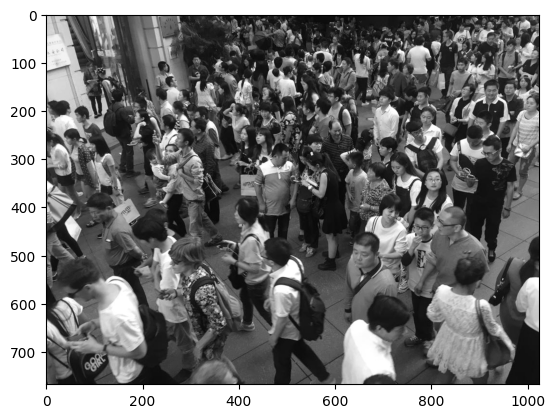

In [30]:
ds = MyDataset(valid, aug_val)
d = ds[0][0]
plt.imshow(d, cmap='gray')

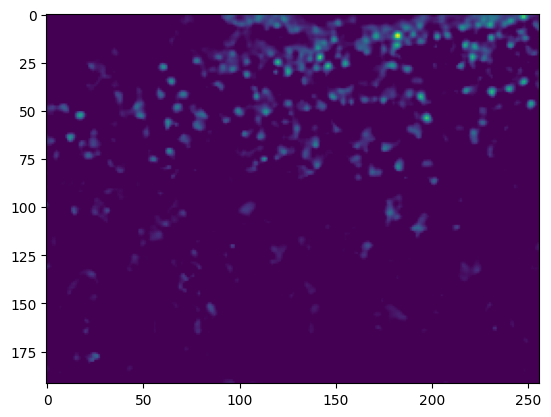

In [31]:
plt.imshow(model(d.unsqueeze(0)).detach()[0])

In [32]:
model(d.unsqueeze(0)).detach()[0].sum()

tensor(171.5078)